# ImprovedSCIT_2010

- **Paper**: An Improved Storm Cell Identification and Tracking (SCIT) Algorithm based on DBSCAN Clustering and JPDA Tracking Methods.

- $\textbf{\textcolor{red}{Identification}}$:
    - **Identification**:
        + apply multiple thresholds
        + for each threshold, use DBSCAN to detect clusters, each cluster -> a single storm
        + *combining*: only use highest & lowest dbz => inner most are saved with being represented by largest possible area

    - **Representation**:
        + draw a set of particles uniformly inside each storm

- $\textbf{\textcolor{blue}{Tracking}}$:
    - **Estimate motion**:
        + Initially, use the user input estimate motion. Later, use the previous estimated motion 
        + storm => average of user input convex field (initially)
        + subset of storms => the same velocity (later)
        + particle within storm => same velocity

    - **Matching**:
        + *Particles matching*: construct a disparity matrix and apply Hungarian algorithm. The case function between 2 particles includes:
            + displacement between 2 particles in t and t+1.
            + similarity function between estimated vs. previous velocities

        + *Cells matching*:
            + count number of particles from storm 1 corresponding with storm 2 for each storm pairs
            + generate the 2 probabilites matrix: $P_A$ and $P_B$
            + soft classification using only the first 3 stages of Hungarian matching.
            + split & merge storms will form a group of storms.
            + a single displacement will be applied for a single group.

        - *Vector estimation*:
            + centroid displacement.
            + split & merge: average of centroids by area.
    
- $\textbf{\textcolor{yellow}{Nowcasting}}$:
    + Not mentioned, hence applied the linear interpolation as the previous.

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

### Dataset 1 - Windy

In [61]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm

data_name = "philippines_13.269_123.832"
SOURCE_PATH = f"data/image_old/{data_name}"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:50]

img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 50/50 [01:10<00:00,  1.42s/it]

Number of frames: 50


### Dataset 2 - Korean

In [62]:
# from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline
# from tqdm.notebook import tqdm

# data_name = "KGRR"

# SOURCE_PATH = f"data/numpy_grid/{data_name}"

# img_paths = [
#     os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')
# ]

# print(f"-" * 20)

# dbz_maps = []

# for path in tqdm(img_paths, desc="Processing images and detecting storms"):
#     img = read_numpy_grid(path)
#     dbz_map = nexrad_numpy_preprocessing_pipeline(img)
#     dbz_maps.append(np.nan_to_num(dbz_map))

# dbz_map_sample = dbz_maps[0]
# img_shape = (dbz_map_sample.shape[0], dbz_map_sample.shape[1], 3)
# print(f"Image shape: {img_shape}")

# print(f"Number of frames: {len(dbz_maps)}")

## 1. Identification

- Implement class `ParticleStorm` which stores the information about its contour shape, and its particles.


In [63]:
from src.identification import ClusterIdentifier, HypothesisIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from shapely import Polygon
from sklearn.cluster import KMeans
from copy import deepcopy
from shapely.affinity import translate

class ParticleStorm(StormObject):
    centroid: np.ndarray
    particles: list[np.ndarray]                                 # list of particles inside the storm, each particle is represented by its (y,x) coordinate
    estimated_velocity: tuple[float, float] = (None, None)      # estimated movement for the current storm

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], density: float, id: str=""):
        super().__init__(contour=polygon, id=id)
        contour = convert_polygons_to_contours([polygon])[0]
        self.particles = self._sample_particles(contour, density)
        self.centroid = np.array(centroid).astype(np.int64)
    
    def _sample_particles(self, contour: np.ndarray, density: float, shape = img_shape) -> np.ndarray:
        """
        Sample a list of particles inside the contour.

        Args:
            contour (np.ndarray): the list of points, in order, creating the contour.
            div (float, default): determine the number of particles = area / div.
        
        Returns:
            particles (np.ndarray): the list of particles.
        """
        # get the set of points bounded by the contour
        mask = np.zeros(shape=shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=1)
        points = np.argwhere(mask > 0)

        # cluster them 
        n_clusters = int(cv2.contourArea(contour) * density) + 1
        k_means = KMeans(n_clusters)
        k_means.fit(points)

        return k_means.cluster_centers_.astype(np.int64)
    
    def copy(self) -> "ParticleStorm":
        # Allocate new object without calling __init__
        new_obj = self.__class__.__new__(self.__class__)

        # Copy all attributes manually (deepcopy for safety)
        new_obj.__dict__ = deepcopy(self.__dict__)
        new_obj.id = "pred_" + new_obj.id

        return new_obj
    
    def get_num_particles(self):
        """
        Get the number of particles.
        """
        return len(self.particles)

    def make_move(self, displacement: np.ndarray):
        """
        Move the storm by the given displacement.
        """
        try:
            dy, dx = displacement
            self.contour = translate(self.contour, xoff=dx, yoff=dy)
            self.centroid = (self.centroid + displacement).astype(np.int64)
            self.particles = [particle + displacement for particle in self.particles]
        except Exception as e:
            print(f"Movement: {displacement}")
            print(f"Contour = {self.contour}")
            raise e

    def assign_movement(self, velocity: tuple[float, float]):
        self.estimated_velocity = velocity

    def assign_trec_movement(self, vy: np.ndarray, vx: np.ndarray, block_size: int):
        """
        Assign the estimated movement to the storm.
        Args:
            vy (np.ndarray): the y-component movement field. Unit: pixels / hr.
            vx (np.ndarray): the x-component movement field. Unit: pixels / hr.
            block_size (int): the size of each block in TREC method.
        """
        if len(vy) == 0 or len(vx) == 0:
            raise ValueError("vy, vx must be provided.")

        y_idx = np.round(self.particles[:, 0] / block_size).astype(np.int64)
        x_idx = np.round(self.particles[:, 1] / block_size).astype(np.int64)

        particle_velocities_y = vy[y_idx, x_idx]
        particle_velocities_x = vx[y_idx, x_idx]

        self.estimated_velocity = (np.mean(particle_velocities_y), np.mean(particle_velocities_x))  # in pixels per second

class DbzStormsMap(StormsMap):
    storms: list[ParticleStorm]
    dbz_map: np.ndarray

    def __init__(self, storms: list[ParticleStorm], time_frame: datetime, dbz_map: np.ndarray):
        """
        Beside 2 default attributes, also keep track of `dbz_map` for computin correlation.
        """
        super().__init__(storms, time_frame)
        self.dbz_map = dbz_map
    
    def _retrieve_block_movement(self, block: np.ndarray, search_region: np.ndarray) -> np.ndarray:
        """
        Find the best matching position of `block` in `search_region` using template matching.
        """
        block = block.astype(np.float32)
        search_region = search_region.astype(np.float32)
        result = cv2.matchTemplate(search_region, block, cv2.TM_CCOEFF_NORMED)
        return np.unravel_index(np.argmax(result), result.shape)

    def trec_estimate(self, next_storms_map: "DbzStormsMap", **kwargs) -> np.ndarray:
        """
        Estimate the movement field for each storm using TREC method. Use for the first guess.
        """
        dbz_map_1 = self.dbz_map
        dbz_map_2 = next_storms_map.dbz_map

        dt = (next_storms_map.time_frame - self.time_frame).total_seconds() / 3600.0    # time difference in hours

        # retrieve parameters of estimatied-motion map.
        block_size = kwargs.get("block_size", 64)
        stride = kwargs.get("stride", block_size)
        max_velocity = kwargs.get("max_velocity", 100)
        buffer = int(max_velocity * dt)             # search region = block + expanded by local_buffer

        H, W = dbz_map_2.shape

        ys = list(range(0, H-block_size+1, stride))     # ys: list[start_idx of H-axis]
        xs = list(range(0, W-block_size+1, stride))     # xs: list[start_idx of W-axis]

        vy = np.zeros(shape=(len(ys), len(xs)))         # vy: keep the y-value of movement at corresponding position
        vx = np.zeros_like(vy)                          # vx: keep the y-value of movement at corresponding position

        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                block = dbz_map_1[y:y+block_size, x:x+block_size]
                if np.std(block) < 1e-3:    # case std is too small => continue
                    continue

                # otherwise: get the search region
                y_search_low, y_search_high = max(0,y-buffer), min(H,y + block_size + buffer)   # ensure the seach region is not overflow.
                x_search_low, x_search_high = max(0,x-buffer), min(W,x + block_size + buffer)

                search_region = dbz_map_2[y_search_low:y_search_high, x_search_low:x_search_high]
                dy, dx = self._retrieve_block_movement(block, search_region)

                y_center, x_center = y_search_low + dy + block_size / 2, x_search_low + dx + block_size / 2
                y_block_center = y + block_size / 2
                x_block_center = x + block_size / 2

                # displacement from dbz_map_1 -> dbz_map_2 = center - original position
                vy[i][j] = y_center - y_block_center
                vx[i][j] = x_center - x_block_center

        vy = vy / dt        # convert to pixels / hr
        vx = vx / dt        # convert to pixels / hr

        # predict the movement of each storm
        for storm in self.storms:
            storm.assign_trec_movement(vy, vx, block_size)

In [64]:
THRESHOLD = 35
DISTANCE_DBZ = 5
FILTER_AREA = 20        # storm with area under this threshold => cancel
FILTER_CENTER = 10
DENSITY = 0.05           # number of particles of a storm = area * DENSITY

Processing images and detecting storms: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 11
Time: 2025-01-08 03:16:44 | Detected storms: 14
Time: 2025-01-08 03:22:45 | Detected storms: 9
Time: 2025-01-08 03:28:45 | Detected storms: 11
Time: 2025-01-08 03:34:45 | Detected storms: 9
Time: 2025-01-08 03:40:45 | Detected storms: 13
Time: 2025-01-08 03:46:46 | Detected storms: 20
Time: 2025-01-08 03:52:46 | Detected storms: 14
Time: 2025-01-08 03:58:46 | Detected storms: 11
Time: 2025-01-08 04:04:46 | Detected storms: 13
Time: 2025-01-08 04:10:47 | Detected storms: 12
Time: 2025-01-08 04:16:47 | Detected storms: 14
Time: 2025-01-08 04:22:47 | Detected storms: 21
Time: 2025-01-08 04:28:47 | Detected storms: 16
Time: 2025-01-08 04:34:48 | Detected storms: 17
Time: 2025-01-08 04:40:48 | Detected storms: 11
Time: 2025-01-08 04:46:48 | Detected storms: 9
Time: 2025-01-08 04:52:48 | Detected storms: 15
Time: 2025-01-08 04:58:49 | Detected storms: 13
Time: 2025-01-08 05:04:49 | Detected storms: 12
Time: 2025-01-08 05:10

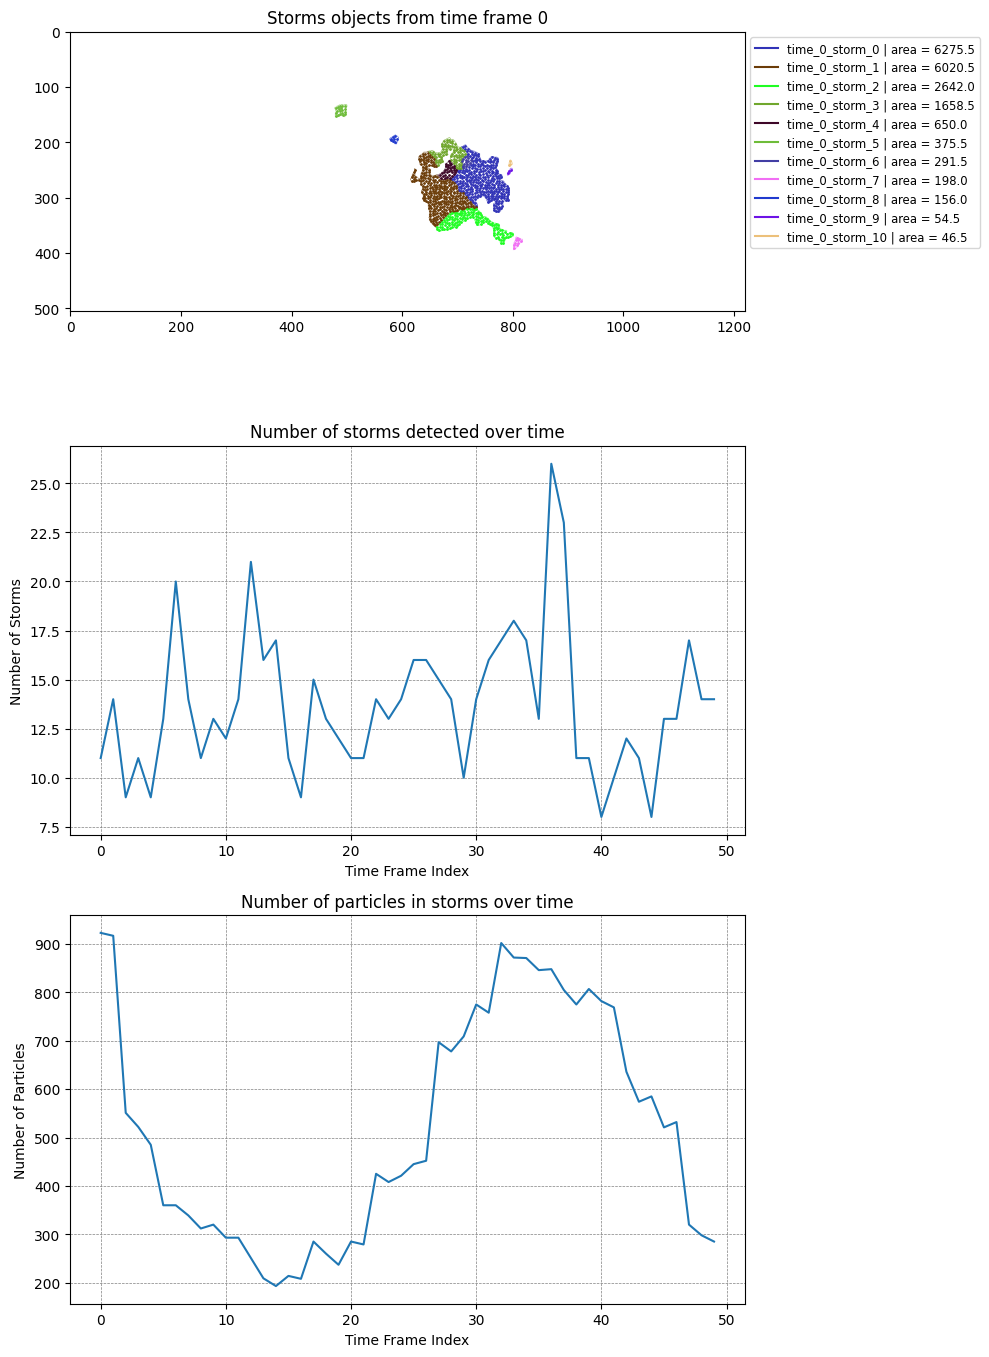

In [66]:
identifier = HypothesisIdentifier(distance_dbz_threshold=DISTANCE_DBZ, filter_center=FILTER_CENTER)
storms_map_time_lst: list[DbzStormsMap] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA)
     # convert contours to polygons and sort by area
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")
    # time_frame = datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute weighted centroid
        total_weight = weights.sum()
        if total_weight == 0:
            centroid = (np.nan, np.nan)  # or fallback
        else:
            cx = (x_idx * weights).sum() / total_weight
            cy = (y_idx * weights).sum() / total_weight
            centroid = (int(cy), int(cx))       # swapped to (y,x)

        storms.append(ParticleStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}", density=DENSITY
            ))
        
    storms_map = DbzStormsMap(storms, time_frame=time_frame, dbz_map=dbz_map)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(10, 14))

plt.subplot(3,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    x_centroid, y_centroid = storm.centroid
    particles = storm.particles
    x_points, y_points = particles[:, 1], particles[:, 0]
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_points, y_points, color=np.array(color)/255.0, s=1)
    # plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(loc="upper left", fontsize='small', ncol=1, bbox_to_anchor=(1, 1))
plt.imshow(blank_image,cmap="gray")
plt.title('Storms objects from time frame 0')
plt.tight_layout()


plt.subplot(3,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.tight_layout()

plt.subplot(3,1,3)
number_of_storms = [np.sum([storm.get_num_particles() for storm in storms_map.storms]) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of particles in storms over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Particles')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.tight_layout()
plt.show()

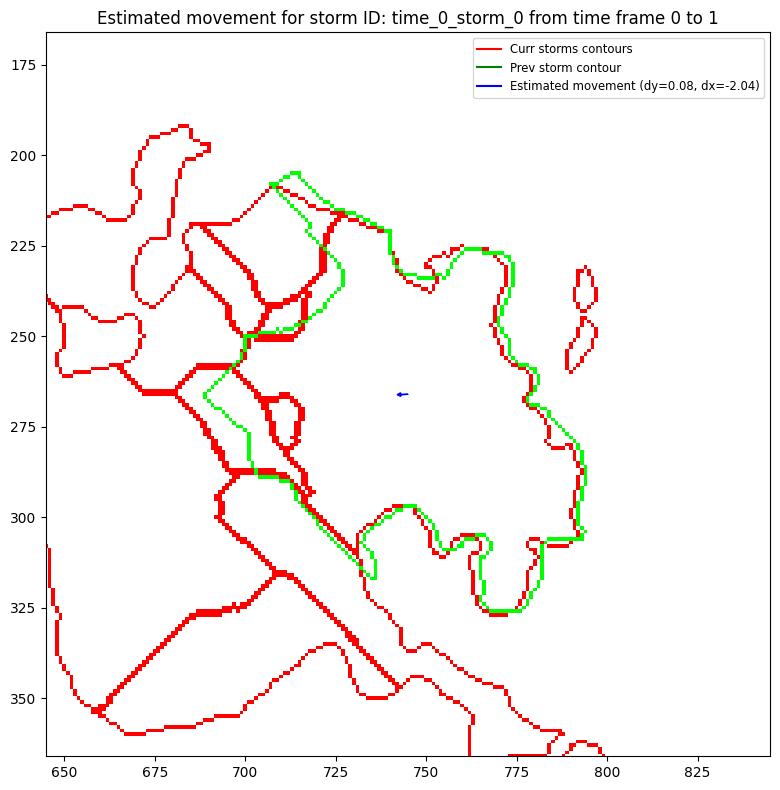

In [67]:
# try initial guess using TREC estimation
prev_idx = 0
curr_idx = 1

storms_map_1 = storms_map_time_lst[prev_idx]
storms_map_2 = storms_map_time_lst[curr_idx]

dt = (storms_map_2.time_frame - storms_map_1.time_frame).total_seconds() / 3600.0

storms_map_1.trec_estimate(next_storms_map=storms_map_2)

# plot estimated velocity of each storm in the first frame
plt.figure(figsize=(8, 8))
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

curr_storms_contours = convert_polygons_to_contours([storm.contour for storm in storms_map_2.storms])
cv2.drawContours(blank_image, curr_storms_contours, -1, (255,0,0), thickness=1)
plt.plot([], [], color='red', label=f"Curr storms contours")

storm_idx = 0
prev_storm = storms_map_1.storms[storm_idx]
vy, vx = prev_storm.estimated_velocity
dy = vy * dt
dx = vx * dt

centroid_y, centroid_x = prev_storm.centroid

cv2.drawContours(blank_image, convert_polygons_to_contours([prev_storm.contour]), -1, (0,255,0), thickness=1)
plt.plot([], [], color='green', label=f"Prev storm contour")
plt.arrow(centroid_x, centroid_y, dx, dy, color='blue', head_width=1, head_length=1)

plt.plot([], [], color='blue', label=f"Estimated movement (dy={dy:.2f}, dx={dx:.2f})")
plt.legend(loc="upper right", fontsize='small', ncol=1, bbox_to_anchor=(1, 1))
plt.imshow(blank_image,cmap="gray")
plt.title(f'Estimated movement for storm ID: {prev_storm.id} from time frame {prev_idx} to {curr_idx}')

plt.xlim(centroid_x - 100, centroid_x + 100)
plt.ylim(centroid_y + 100, centroid_y - 100)

plt.tight_layout()
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**:

    + Match 1-one-1 between 2 lists of particles.    
    + Count number of corresponding particles matching between 2 storms.
    + Construct 2 probabilites matrices.
    + Soft matching between 2 lists of storms.

- **class** $\textcolor{orange}{\text{ParticleMatcher}}$: make one-to-one assignments between particle in $t$ and $t+1$. The disparity matrix is constructed as follow:

    + **Input**: An estimated vector for each particle at time $t$: $V_t$
    + Construct the displacement matrix: 
        $$V'_{t+1}{(i,j)} = \frac{p_{t+1}(j)-p_t(i)}{dt}$$
    + Penalty terms for changes in direction of movement:
        $$T_D = 1 - \frac{V_t * V'_{t+1}}{\left\|V_t\right\|\left\|V'_{t+1}\right\|}$$
    + Penalty terms for changes in speed:
        $$T_S = 1 - \frac{2\sqrt{\Delta_{max} * S}}{\Delta_{max} + S}$$
        where $S = \max{(\Delta_{max} - \left|V'_{t+1}-V_t\right|, 0)}$
    + Cost function:
        $$C = w_D * T_D + w_S * T_S$$
    
    + **Penalty terms for constraint violation**: any entry with either $T_D >= 1$ or $T_S == 1$ will be set to infinity.

- **class** $\textcolor{ForestGreen}{\text{StormMatcher}}$: make a soft assignment between 2 storms, from the disparity matrix that is constructed from probability of particle matching between each pair of storms

In [68]:
from dataclasses import dataclass, field
import warnings

@dataclass
class CellSubset:
    sources: set[int]      # list of indices of source storms
    targets: set[int]      # list of indices of target storms
    velocity: np.ndarray = field(default=None)   # combined velocity from source to target storms

    def add_cell(self, source: int = None, target: int = None):
        """
        add a source/target storm index to the subcell.
        """
        if source is not None:
            self.sources.add(source)
        if target is not None:
            self.targets.add(target)
    
    def merge_subcell(self, other: "CellSubset"):
        """
        merge another subcell into this one.
        """
        self.sources = self.sources.union(other.sources)
        self.targets = self.targets.union(other.targets)

    def contains(self, storm_order: int, is_source: bool=True) -> bool:
        """
        check if the cell contains the given source/target storm index.
        """
        return (storm_order in self.sources) if is_source else (storm_order in self.targets)
    
    def assign_velocity(self, velocity: np.ndarray):
        self.velocity = velocity

In [69]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker, reduced_soft_hungarian

@dataclass
class Particle:
    position: np.ndarray
    storm_order: int        # order of the storm this particle belongs to

class ParticleMatcher(BaseMatcher):
    def _construct_disparity_matrix(
            self, particle_lst1: list[Particle], particle_lst2: list[Particle], estimated_vectors: np.ndarray, 
            dt: float, weights: list[float], max_velocity_norm: float, eps: float = 1e-7
        ):
        """
        Construct a disparity matrix for 2 lists of particles.

        Parameters:
            particle_lst1 (list[Particle]): The first list of particles.
            particle_lst2 (list[Particle]): The second list of particles.
            estimated_vectors (np.ndarray): The estimated movement vectors for each particle in `particle_lst1`.
            weights (list[float]): the list of nonnegative- and sum-to-1 weights.

        Returns:
            cost_matrix, T_D, T_S (tuple[np.ndarray, np.ndarray]): The constructed disparity matrix and distance matrix for later verification.
        """
        # print(f"ParticleMatcher weights: {weights}")
        assert all([all([w >= 0 for w in weights]), np.sum(weights) == 1]), "weights must not be negative and must sum to 1."
        n2 = len(particle_lst2)
        coord_1 = np.array([p.position for p in particle_lst1])
        coord_2 = np.array([p.position for p in particle_lst2])

        path_vector_matrix = (coord_2[np.newaxis, :, :] - coord_1[:, np.newaxis, :]) / dt          # shape: (n1, n2, 2)
        estimated_vector_matrix = np.repeat(estimated_vectors[:, np.newaxis, :], n2, axis=1)       # shape: (n1, n2, 2)

        # compute T_D
        dot_product = np.sum(path_vector_matrix * estimated_vector_matrix, axis=-1)  # (n1, n2)
        norms = (np.linalg.norm(path_vector_matrix, axis=-1) *
                    np.linalg.norm(estimated_vector_matrix, axis=-1) + eps)
        
        T_D = 1 - dot_product / norms   # shape: (n1, n2)
        
        # compute T_S
        norm_displ_matrix = np.linalg.norm(path_vector_matrix - estimated_vector_matrix, axis=-1)       # shape: (n1, n2)
        delta_max = np.clip(max_velocity_norm - norm_displ_matrix, a_min=0, a_max=max_velocity_norm)
        T_S = 1 - (2 * np.sqrt(max_velocity_norm * delta_max)) / (max_velocity_norm + delta_max + eps)   # shape: (n1, n2)

        # compute cost matrix
        cost_matrix = weights[0] * T_D + weights[1] * T_S

        return cost_matrix, T_D, T_S
    
    def match_particles(
            self, particle_lst1: list[Particle], particle_lst2: list[Particle], estimated_vectors: np.ndarray, dt: float,
            max_velocity_norm: float, weights: list[float] = [0.5, 0.5]
        ) -> np.ndarray:
        """
        Match particles between 2 lists of particles.
        Parameters:
            particle_lst1 (list[Particle]): The first list of particles.
            particle_lst2 (list[Particle]): The second list of particles.
            max_velocity_norm (float): The maximum velocity norm allowed for a particle to be considered a match.
            weights (list[float], default=[0.5, 0.5]): the list of nonnegative- and sum-to-1 weights.
        Returns:
            assignments (np.ndarray): The array of matched indices between the 2 lists of particles.
        """
        # print(f"ParticleMatcher weights: {weights}")
        cost_matrix, T_D, T_S = self._construct_disparity_matrix(
            particle_lst1, particle_lst2, estimated_vectors=estimated_vectors, dt=dt,
            max_velocity_norm=max_velocity_norm, weights=weights
        )
        max_bound = 1 - 1e-5
        invalid_mask = (T_D >= max_bound) | (T_S >= max_bound)
        cost_matrix[invalid_mask] = 1000                            # assign a large cost to invalid matches

        row_ind, col_ind = self._hungarian_matching(cost_matrix)
        assignment_mask = np.zeros_like(invalid_mask, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        return np.argwhere(assignment_mask & np.logical_not(invalid_mask))
    
class SubsetResolver:
    matching_threshold: float

    def __init__(self, matching_threshold: float):
        self.matching_threshold = matching_threshold

    def create_subsets(self, assignments: list[tuple[int, int]]) -> list[CellSubset]:
        """
        create subsets of storms based on the assignments between 2 time frames.
        """
        subcells: list[CellSubset] = []

        for prev_idx, curr_idx in assignments:
            prev_subcell = None
            curr_subcell = None

            # find if there is existing subcell containing prev_idx or curr_idx
            for subcell in subcells:
                if subcell.contains(prev_idx, is_source=True):
                    prev_subcell = subcell
                if subcell.contains(curr_idx, is_source=False):
                    curr_subcell = subcell
            
            # case 1: both are not belonged to any subcell => create new subcell
            if not prev_subcell and not curr_subcell:
                # create new subcell
                new_subcell = CellSubset(sources={prev_idx}, targets={curr_idx})
                subcells.append(new_subcell)
                continue
                
            # case 2: only one of them is belonged to a subcell => add the other index to that subcell
            if prev_subcell and not curr_subcell:
                prev_subcell.add_cell(target=curr_idx)
                continue
            if not prev_subcell and curr_subcell:
                curr_subcell.add_cell(source=prev_idx)
                continue
                
            # case 3: both are belonged to different subcells => merge 2 subcells
            if prev_subcell != curr_subcell:
                prev_subcell.merge_subcell(curr_subcell)
                subcells.remove(curr_subcell)
        
        return subcells

    def resolve_subsets(
            self, subset_lst: list[CellSubset], storms_map_lst_1: DbzStormsMap, storms_map_lst_2: DbzStormsMap, 
            max_velocity: float, weights: list[float] = [0.5, 0.5]
        ) -> list[CellSubset]:
        """
        resolve the subset to get final assignments between 2 time frames.
        """
        # compute maximum displacement
        dt = (storms_map_lst_2.time_frame - storms_map_lst_1.time_frame).total_seconds() / 3600.0
        particles_matcher = ParticleMatcher()

        valid_cell_subsets: list[CellSubset] = []

        for subset in subset_lst:
            prev_storms_lst: list[tuple[int, ParticleStorm]] = [(idx, storm) for idx, storm in enumerate(storms_map_lst_1.storms) if idx in subset.sources]
            curr_storms_lst: list[tuple[int, ParticleStorm]] = [(idx, storm) for idx, storm in enumerate(storms_map_lst_2.storms) if idx in subset.targets]

            particles_prev: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in prev_storms_lst for particle in storm.particles]
            particles_curr: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in curr_storms_lst for particle in storm.particles]

            estimated_vectors = np.array([storm.estimated_velocity for _, storm in prev_storms_lst for _ in storm.particles])           # scale to the time difference

            # match particles
            particle_assignments = particles_matcher.match_particles(
                particles_prev, particles_curr, estimated_vectors, max_velocity_norm = max_velocity, weights = weights, dt=dt
            )

            # count number of matched particles between each pair of storms
            matching_count = np.zeros((len(storms_map_lst_1.storms), len(storms_map_lst_2.storms)), dtype=np.int64)

            for idx1, idx2 in particle_assignments:
                matching_count[particles_prev[idx1].storm_order, particles_curr[idx2].storm_order] += 1
            
            # compute probability matrix
            ## p_A: Probability of matching where the denominator is the number of particles in the previous storm
            ## p_B: Probability of matching where the denominator is the number of particles in the curr storm
            p_A = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_1.storms])[:, np.newaxis]
            p_B = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_2.storms])[np.newaxis, :]

            p = np.max([p_A, p_B], axis=0)
            assignments = np.argwhere(p >= self.matching_threshold)

            if len(assignments) == 0:
                continue

            prev_storms_indices = assignments[:, 0]
            curr_storms_indices = assignments[:, 1]
            
            # combine centroids of storms with weighted area.
            def combine_centroid(storm_indices: list[int], storms_map: DbzStormsMap) -> np.ndarray:
                total_area = 0
                combined_centroid = np.array([0.0, 0.0])

                for idx in storm_indices:
                    storm = storms_map.storms[idx]
                    area = storm.contour.area
                    centroid = storm.centroid

                    combined_centroid += area * centroid
                    total_area += area
                
                if total_area == 0:
                    print(f"Total area is zero when combining centroids. Error check: ")
                    for idx in storm_indices:
                        storm = storms_map.storms[idx]
                        print(f"\t- Storm ID: {storm.id} | Area: {storm.contour.area} | Centroid: {storm.centroid}")
                    # return np.array([np.nan, np.nan])
                    return np.array([0.0, 0.0])
                
                combined_centroid /= total_area

                return combined_centroid.astype(np.int64)

            prev_combined_centroid = combine_centroid(prev_storms_indices, storms_map_lst_1)
            curr_combined_centroid = combine_centroid(curr_storms_indices, storms_map_lst_2)
            velocity = (curr_combined_centroid - prev_combined_centroid) / dt
            if np.any(np.isnan(velocity)):
                warnings.warn(f"NaN velocity detected at {subset}.")
            
            valid_subset = CellSubset(sources=set(prev_storms_indices.tolist()), targets=set(curr_storms_indices.tolist()))
                
            valid_subset.assign_velocity((curr_combined_centroid - prev_combined_centroid) / dt)

            valid_cell_subsets.append(valid_subset)
        
        return valid_cell_subsets

class StormMatcher(BaseMatcher):
    particles_matcher: ParticleMatcher
    subset_resolver: SubsetResolver
    max_velocity: float
    weights: list[float]                    # weights for distance and shape

    def __init__(self, max_velocity: float, matching_threshold: float, weights: list[float] = [0.5, 0.5]):
        super().__init__()
        self.particles_matcher = ParticleMatcher()
        self.max_velocity = max_velocity
        self.subset_resolver = SubsetResolver(matching_threshold=matching_threshold)
        self.weights = weights

    def _construct_disparity_matrix(
            self, storms_lst1: list[ParticleStorm], storms_lst2: list[ParticleStorm]
        ):
        pass

    def match_storms(
            self, storms_map_lst_1: DbzStormsMap, storms_map_lst_2: DbzStormsMap, 
        ) -> list[CellSubset]:
        """
        Match storms between 2 time frame.
        
        Args:
            storms_lst_1 (list[ParticleStorm]): The list of storms at time t.
            storms_lst_2 (list[ParticleStorm]): The list of storms at time t+1.

        Returns:
            subset_assignments (list[CellSubset]): The list of matched storm subsets between the 2 time frames.
        """
        # get particles lists for both time frames
        particles_prev: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in enumerate(storms_map_lst_1.storms) for particle in storm.particles]
        particles_curr: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in enumerate(storms_map_lst_2.storms) for particle in storm.particles]

        # compute maximum displacement
        dt = (storms_map_lst_2.time_frame - storms_map_lst_1.time_frame).total_seconds() / 3600.0
        estimated_vectors = np.array([storm.estimated_velocity for storm in storms_map_lst_1.storms for _ in storm.particles])

        # match particles
        particle_assignments = self.particles_matcher.match_particles(
            particles_prev, particles_curr, estimated_vectors, max_velocity_norm=self.max_velocity, weights=self.weights, dt=dt
        )

        # count number of matched particles between each pair of storms
        matching_count = np.zeros((len(storms_map_lst_1.storms), len(storms_map_lst_2.storms)), dtype=np.int64)

        for idx1, idx2 in particle_assignments:
            matching_count[particles_prev[idx1].storm_order, particles_curr[idx2].storm_order] += 1
        
        # compute probability matrix
        ## p_A: Probability of matching where the denominator is the number of particles in the previous storm
        ## p_B: Probability of matching where the denominator is the number of particles in the curr storm
        p_A = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_1.storms])[:, np.newaxis]
        p_B = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_2.storms])[np.newaxis, :]

        # find the soft-hungarian assignment
        assignments_A = reduced_soft_hungarian(1 - p_A)
        assignments_B = reduced_soft_hungarian(1 - p_B)

        # drop invalid assignments
        assignments = []
        for prev_idx, curr_idx in list(set(assignments_A).union(set(assignments_B))):
            if matching_count[prev_idx, curr_idx] == 0:
                continue
            assignments.append((prev_idx, curr_idx))

        subsets = self.subset_resolver.create_subsets(assignments)

        return self.subset_resolver.resolve_subsets(
            subsets, storms_map_lst_1, storms_map_lst_2, self.max_velocity, self.weights
        )

In [70]:
MAX_VELOCITY = 100          # in km/h
MATCHING_THRESHOLD = 0.5    # minimum probability threshold for matching between 2 storms
WEIGHTS = [0.5, 0.5]        # weights for T_S and T_D

matcher = StormMatcher(max_velocity=MAX_VELOCITY, matching_threshold=MATCHING_THRESHOLD)

prev_idx, curr_idx = 12, 13
storms_map_1 = storms_map_time_lst[prev_idx]
storms_map_2 = storms_map_time_lst[curr_idx]

storms_map_1.trec_estimate(next_storms_map=storms_map_2)

dt = (storms_map_2.time_frame - storms_map_1.time_frame).total_seconds() / 3600.0

subsets = matcher.match_storms(
    storms_map_lst_1=storms_map_1, storms_map_lst_2=storms_map_2
)

# estimed velocities for each subset
for subset in subsets:
    vy, vx = subset.velocity
    print(f"Matched sources: {subset.sources} -> targets: {subset.targets}")
    print(f"\tEstimated velocity: vy = {vy:.2f}, vx = {vx:.2f}")

# estimated velocities for each storm in the first frame
for prev_storm in storms_map_1.storms:
    vy, vx = prev_storm.estimated_velocity
    print(f"Storm ID: {prev_storm.id} | Estimated velocity: vy = {vy:.2f}, vx = {vx:.2f}")

Matched sources: {17} -> targets: {12}
	Estimated velocity: vy = -20.00, vx = -40.00
Matched sources: {2} -> targets: {2}
	Estimated velocity: vy = 10.00, vx = -80.00
Matched sources: {1, 18, 12, 7} -> targets: {0}
	Estimated velocity: vy = -10.00, vx = 0.00
Matched sources: {5} -> targets: {6}
	Estimated velocity: vy = -20.00, vx = -40.00
Matched sources: {8} -> targets: {11}
	Estimated velocity: vy = -90.00, vx = -10.00
Matched sources: {9, 15} -> targets: {7}
	Estimated velocity: vy = 0.00, vx = -30.00
Matched sources: {6} -> targets: {10}
	Estimated velocity: vy = -10.00, vx = -30.00
Matched sources: {20} -> targets: {15}
	Estimated velocity: vy = 0.00, vx = -60.00
Matched sources: {11} -> targets: {9}
	Estimated velocity: vy = -10.00, vx = -50.00
Matched sources: {3, 13} -> targets: {3, 5}
	Estimated velocity: vy = 0.00, vx = -90.00
Matched sources: {0} -> targets: {1}
	Estimated velocity: vy = 40.00, vx = -20.00
Matched sources: {19} -> targets: {14}
	Estimated velocity: vy = 10.

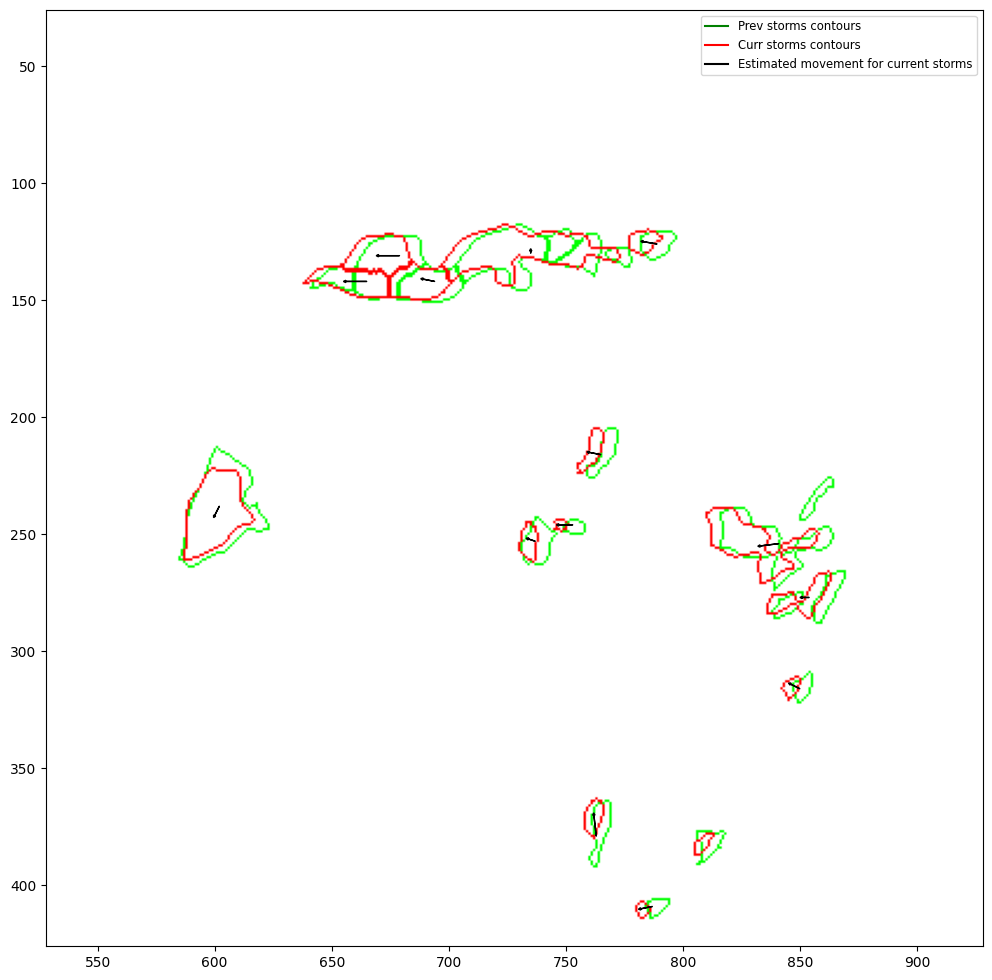

In [71]:
# plot estimated movement of each matched subset
plt.figure(figsize=(10, 10))
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

# plot previous storms contours
prev_storms_contours = convert_polygons_to_contours([storm.contour for storm in storms_map_1.storms])
cv2.drawContours(blank_image, prev_storms_contours, -1, (0,255,0), thickness=1)
plt.plot([], [], color='green', label=f"Prev storms contours")

# plot current storms contours
curr_storms_contours = convert_polygons_to_contours([storm.contour for storm in storms_map_2.storms])
cv2.drawContours(blank_image, curr_storms_contours, -1, (255,0,0), thickness=1)
plt.plot([], [], color='red', label=f"Curr storms contours")

# combined centroid for display
combined_y_list, combined_x_list = [], []

# plot movement for each subset
for subset in subsets:
    for curr_idx in subset.targets:
        curr_storm = storms_map_2.storms[curr_idx]
        vy, vx = subset.velocity
        dy = vy * dt
        dx = vx * dt

        centroid_y, centroid_x = curr_storm.centroid
        combined_y_list.append(centroid_y)
        combined_x_list.append(centroid_x)
        plt.arrow(centroid_x-dx, centroid_y-dy, dx, dy, color='black', head_width=1, head_length=1)

combined_y = int(np.mean(combined_y_list))
combined_x = int(np.mean(combined_x_list))

plt.plot([], [], color='black', label=f"Estimated movement for current storms")
plt.legend(loc="upper right", fontsize='small', ncol=1, bbox_to_anchor=(1, 1))
plt.imshow(blank_image,cmap="gray")
plt.ylim(combined_y + 200, combined_y - 200)
plt.xlim(combined_x - 200, combined_x + 200)
plt.tight_layout()
plt.show()

### 2.2 Implemetation of `TrackingHistory`

In [72]:
@dataclass
class StormTrack:
    """
    Track: only store 1 storm at each time frame.
    """
    id: int
    storm: ParticleStorm
    time_frame: datetime
    active: bool = field(default=True)

    def deactivate(self):
        self.active = False
    
    def get_velocity(self):
        # get estimated velocity of the storm, return (None, None) if not available
        return self.storm.estimated_velocity

In [73]:
from copy import deepcopy

class TrackingHistory(BaseTrackingHistory):
    tracks: list[StormTrack]

    def __init__(self, storms_map: StormsMap):
        self.tracks = []
        for storm in storms_map.storms:
            self.tracks.append(self._initialize_track(storm, storms_map.time_frame))

        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
    
    def _initialize_track(self, storm: ParticleStorm, time_frame: datetime):
        return StormTrack(
            id=len(self.tracks),
            storm=storm,
            time_frame=time_frame
        )

    def _copy_track(self, track: dict) -> dict:
        pass

    def _get_track(self, storm_id: str) -> StormTrack:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track, is_active (tuple[dict, bool]): the track of the storm and whether it is active.
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm {storm_id} not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id]
    
    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> ParticleStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history. Unit: pixel/hr.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track = self._get_track(storm_id)
        if not track.active:
            print(f"⚠️ Storm {storm_id} has been expired")
        
        curr_storm = track.storm
        velocity = np.array(curr_storm.estimated_velocity)
        if velocity[0] is None or velocity[1] is None:
            movement = default_motion * dt
        else:
            movement = velocity * dt

        new_storm = curr_storm.copy()
        new_storm.make_move(movement)

        return new_storm

    def update(
            self, curr_storms_map: DbzStormsMap
        ):
        """
        Update the tracking history with new assignments and storms map.

        Args:
            subset_assignments (list[CellSubset]): list of subset assignments between previous and current storms maps.
            storms_map (StormsMap): the current storms map.
        """
        active_lst = []
        curr_time = curr_storms_map.time_frame

        for storm in curr_storms_map.storms:
            if storm.estimated_velocity[0] is None or storm.estimated_velocity[1] is None:  # in case there is no estimated velocity, assign zero movement
                storm.assign_movement(np.array([0,0]))
            
            new_track = self._initialize_track(storm, curr_time)
            self.tracks.append(new_track)
            active_lst.append(len(self.tracks) - 1)
            self.storm_dict[storm.id] = len(self.tracks) - 1

        # update active status
        for id in self.active_list:
            if id not in active_lst:
                self.tracks[id].deactivate()

        self.active_list = active_lst

    def print_tracks(self, active_only: bool = False):
        for track in self.tracks:
            if active_only and not track.active:
                continue
            status = "ACTIVE" if track.active else "INACTIVE"
            vy, vx = track.get_velocity()
            print(f"Id: {track.id}")
            print(f"Storm: {track.storm.id}")
            print(f"Status: {status}")
            if vy is None or vx is None:
                print(f"Estimated velocity: (N/A, N/A)")
            else:
                print(f"Estimated velocity: ({vy:.2f}, {vx:.2f})")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [74]:
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class Tracker(BaseTracker):
    matcher: StormMatcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float, matching_threshold: float, weights: list[float] = [0.5, 0.5]):
        self.matcher = StormMatcher(max_velocity, matching_threshold, weights)

    def fit(self, storms_map_time_lst: list[DbzStormsMap], test=False, **trec_kwargs):
        """
        Fit the tracker on the list of storms maps over time.
        Args:
            storms_map_time_lst (list[DbzStormsMap]): list of storms maps over time.
            test (bool, default=False): whether to compute the metrics during fitting.
        """
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        block_size = trec_kwargs.get("block_size", 64)
        stride = trec_kwargs.get("stride", block_size)

        # use TREC estimation for the first frame. 
        storms_map_time_lst[0].trec_estimate(next_storms_map=storms_map_time_lst[1], block_size=block_size, stride=stride, max_velocity=self.matcher.max_velocity)

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).total_seconds() / 3600.0

            if test:
                pred_storms_map = DbzStormsMap(
                    storms=[self.tracker.forecast(storm.id, dt=dt) for storm in prev_storms_map.storms],
                    time_frame=curr_storms_map.time_frame, dbz_map=curr_storms_map.dbz_map
                )
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            # get the matched pair
            subset_assignments = self.matcher.match_storms(prev_storms_map, curr_storms_map)
            mapping_curr = []

            # map estimated velocity to each storm in the current map
            for subset in subset_assignments:
                for target_idx in subset.targets:
                    curr_storms_map.storms[target_idx].estimated_velocity = subset.velocity
                    mapping_curr.append(target_idx)

            for storm_idx, storm in enumerate(curr_storms_map.storms):
                if storm_idx not in mapping_curr:
                    storm.assign_movement(np.array([0,0]))

            self.tracker.update(curr_storms_map)

        if test:
            return csi_scores, far_scores, pod_scores, frames
    
    def predict(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> ParticleStorm:
        try:
            return self.tracker.forecast(storm_id, dt, default_motion)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [75]:
MAX_VELOCITY = 100          # in pixel/hr
MATCHING_THRESHOLD = 0.5    # minimum probability threshold for matching between 2 storms
WEIGHTS = [0.5, 0.5]        # weights for T_S and T_D
BLOCK_SIZE = 64

tracker = Tracker(max_velocity=MAX_VELOCITY, matching_threshold=MATCHING_THRESHOLD, weights=WEIGHTS)
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, test=True, block_size=BLOCK_SIZE)

tracker.tracker.print_tracks(active_only=True)

Id: 671
Storm: time_49_storm_0
Status: ACTIVE
Estimated velocity: (0.00, 0.00)
--------------------------------------------------
Id: 672
Storm: time_49_storm_1
Status: ACTIVE
Estimated velocity: (0.00, 0.00)
--------------------------------------------------
Id: 673
Storm: time_49_storm_2
Status: ACTIVE
Estimated velocity: (0.00, 0.00)
--------------------------------------------------
Id: 674
Storm: time_49_storm_3
Status: ACTIVE
Estimated velocity: (0.00, 0.00)
--------------------------------------------------
Id: 675
Storm: time_49_storm_4
Status: ACTIVE
Estimated velocity: (0.00, 0.00)
--------------------------------------------------
Id: 676
Storm: time_49_storm_5
Status: ACTIVE
Estimated velocity: (0.00, 0.00)
--------------------------------------------------
Id: 677
Storm: time_49_storm_6
Status: ACTIVE
Estimated velocity: (0.00, 0.00)
--------------------------------------------------
Id: 678
Storm: time_49_storm_7
Status: ACTIVE
Estimated velocity: (0.00, 0.00)
-----------

## 3. Nowcasting

Compare **Naive** (keep the storms without moving) vs. the current method

In [76]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9154 | FAR: 0.0951 | CSI: 0.8351
	Time 2025-01-08 03:22:45 | POD: 0.7932 | FAR: 0.5218 | CSI: 0.4252
	Time 2025-01-08 03:28:45 | POD: 0.8986 | FAR: 0.1545 | CSI: 0.7719
	Time 2025-01-08 03:34:45 | POD: 0.8945 | FAR: 0.1646 | CSI: 0.7605
	Time 2025-01-08 03:40:45 | POD: 0.6867 | FAR: 0.4947 | CSI: 0.4106
	Time 2025-01-08 03:46:46 | POD: 0.8715 | FAR: 0.1426 | CSI: 0.7611
	Time 2025-01-08 03:52:46 | POD: 0.4461 | FAR: 0.5755 | CSI: 0.2780
	Time 2025-01-08 03:58:46 | POD: 0.8244 | FAR: 0.2353 | CSI: 0.6576
	Time 2025-01-08 04:04:46 | POD: 0.8010 | FAR: 0.1854 | CSI: 0.6775
	Time 2025-01-08 04:10:47 | POD: 0.7098 | FAR: 0.3527 | CSI: 0.5118
	Time 2025-01-08 04:16:47 | POD: 0.8456 | FAR: 0.1519 | CSI: 0.7344
	Time 2025-01-08 04:22:47 | POD: 0.4203 | FAR: 0.6451 | CSI: 0.2383
	Time 2025-01-08 04:28:47 | POD: 0.7256 | FAR: 0.3909 | CSI: 0.4951
	Time 2025-01-08 04:34:48 | 

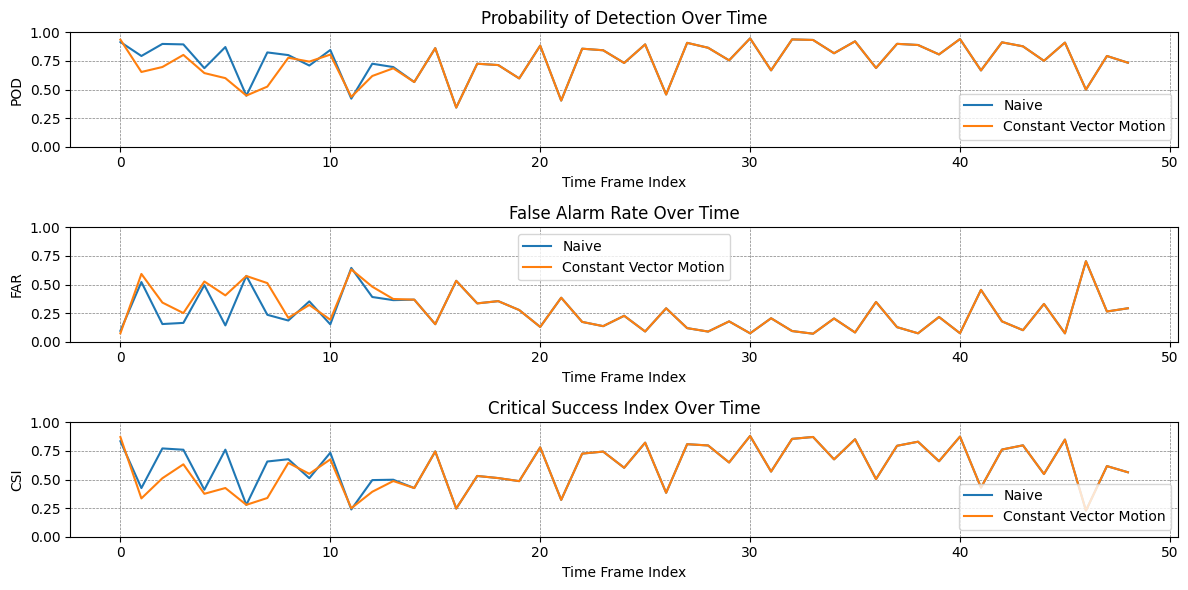

In [77]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()

## 4. Evaluation

In [78]:
import pandas as pd

def forecast_evaluation(lead_time: int, train_len: int):
    pod_scores = []
    csi_scores = []
    far_scores = []
    leading_times = []

    time_list = range(train_len, len(storms_map_time_lst)-lead_time)

    for train_idx in tqdm(time_list, total=len(time_list)):
        test_idx = train_idx + lead_time

        prev_storms_map = storms_map_time_lst[train_idx-1]
        curr_storms_map = storms_map_time_lst[test_idx]

        dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600.0

        tracker = Tracker(max_velocity=MAX_VELOCITY, matching_threshold=MATCHING_THRESHOLD, weights=WEIGHTS)
        tracker.fit(storms_map_time_lst[train_idx - train_len:train_idx], test=False, block_size=BLOCK_SIZE)

        pred_storms_map = DbzStormsMap(
            storms=[tracker.tracker.forecast(storm.id, dt=dt) for storm in prev_storms_map.storms],
            time_frame=curr_storms_map.time_frame, dbz_map=curr_storms_map.dbz_map
        )
        
        pod = pod_score(pred_storms_map, curr_storms_map)
        csi = csi_score(pred_storms_map, curr_storms_map)
        far = far_score(pred_storms_map, curr_storms_map)

        pod_scores.append(pod)
        csi_scores.append(csi)
        far_scores.append(far)
        leading_times.append(dt * 60)  # convert to minutes

    forecast_leads_df = pd.DataFrame({
        'time': [storms_map_time_lst[i+lead_time].time_frame for i in time_list],
        'POD': pod_scores,
        'FAR': far_scores,
        'CSI': csi_scores,
        'leading_time (min)': leading_times
    })

    output_dir = f'output/{data_name}/{lead_time}_frame_leads'
    os.makedirs(output_dir, exist_ok=True)

    forecast_leads_df.to_csv(f'{output_dir}/ISCIT.csv', index=False)

    print(f"Store file successfully to {output_dir}/ISCIT.csv")

    return forecast_leads_df

### 4.1. 3-frame leads

In [79]:
df = forecast_evaluation(lead_time=3, train_len=10)
df

100%|██████████| 37/37 [00:26<00:00,  1.37it/s]

Store file successfully to output/philippines_13.269_123.832/3_frame_leads/ISCIT.csv


,time,POD,FAR,CSI,leading_time (min)
0,2025-01-08 04:28:47,0.411906,0.732920,0.193351,24.016667
1,2025-01-08 04:34:48,0.414338,0.730766,0.195018,24.016667
2,2025-01-08 04:40:48,0.276819,0.799498,0.131580,24.016667
3,2025-01-08 04:46:48,0.313146,0.736120,0.167140,24.016667
4,2025-01-08 04:52:48,0.169098,0.765927,0.108863,24.016667
5,2025-01-08 04:58:49,0.158513,0.766584,0.104245,24.016667
6,2025-01-08 05:04:49,0.155332,0.827393,0.089037,24.016667
7,2025-01-08 05:10:49,0.304616,0.576373,0.215360,24.016667
8,2025-01-08 05:16:49,0.350211,0.654137,0.210671,24.016667
9,2025-01-08 05:22:50,0.307241,0.494974,0.236134,24.016667


### 4.2 5-frame leads

In [80]:
df = forecast_evaluation(lead_time=5, train_len=10)
df

100%|██████████| 35/35 [00:24<00:00,  1.46it/s]

Store file successfully to output/philippines_13.269_123.832/5_frame_leads/ISCIT.csv


,time,POD,FAR,CSI,leading_time (min)
0,2025-01-08 04:40:48,0.186994,0.876120,0.080515,36.033333
1,2025-01-08 04:46:48,0.249078,0.822221,0.115744,36.016667
2,2025-01-08 04:52:48,0.118191,0.885106,0.061864,36.016667
3,2025-01-08 04:58:49,0.170787,0.819909,0.096080,36.033333
4,2025-01-08 05:04:49,0.097173,0.888290,0.054816,36.033333
5,2025-01-08 05:10:49,0.129305,0.786967,0.087506,36.016667
6,2025-01-08 05:16:49,0.224204,0.702830,0.146514,36.016667
7,2025-01-08 05:22:50,0.196888,0.580668,0.154708,36.033333
8,2025-01-08 05:28:50,0.259128,0.623548,0.181308,36.033333
9,2025-01-08 05:34:50,0.266797,0.566008,0.197927,36.016667
